In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import sys
sys.path.insert(0, '../../scripts/')
from common_funcs import common_index, list_intersection, save_list, read_list

In [4]:
from scipy.stats import pearsonr, spearmanr

In [5]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [6]:
clusts = open('../../data/ref/cluster_list.txt').read().split('\n')

In [7]:
species = ['human', 'macaque', 'marmoset', 'mouse']

In [8]:
pairs_use = [('human', 'macaque'), ('human', 'marmoset'), ('human', 'mouse'), ('macaque', 'marmoset'), ('macaque', 'mouse'), ('marmoset', 'mouse')]

# LRT vs logcpm

In [9]:
out_f = '../../data/outputs/gex_de_results/{0}/aggregate/{1}_v_{2}_logfc.tsv'

In [10]:
!ls ../../data/outputs/gex_gls_results/

gls_human_macaque.tsv	gls_human_mouse.tsv	  gls_macaque_mouse.tsv
gls_human_marmoset.tsv	gls_macaque_marmoset.tsv  gls_marmoset_mouse.tsv


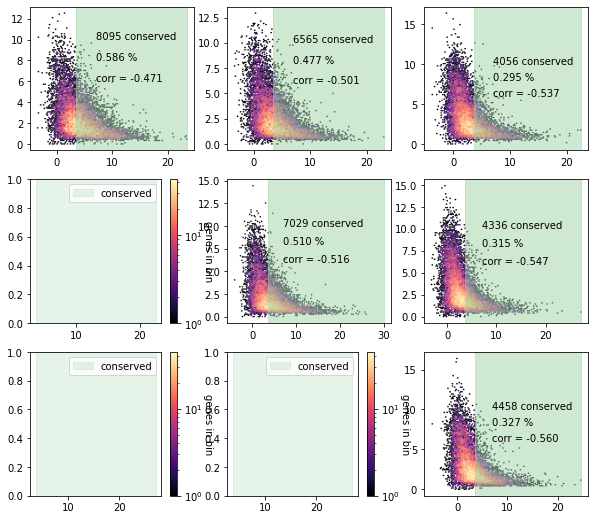

In [11]:
fig, axs = plt.subplots(3, 3, figsize=(10, 9))
# param_use = 
pairs = []
for specie in species[:-1]:
    for specie_2 in species[1:]:
        pairs.append((specie, specie_2))

test_use = 'lrt'
max_t_stat = 30
axs = axs.flatten()
idx = 0
for ax, pair in zip(axs, pairs):
    if pair not in pairs_use:
        ax.axvspan(min_t, max_t, color='#9ED3A4', alpha=0.25, label='conserved')
        ax.legend()
        cbar = ax.figure.colorbar(im, ax=ax)
        cbar.set_label('genes in bin',
                       rotation=270,
                       labelpad=10)
        continue
    spec1, spec2 = pair
    stats = pd.read_csv('../../data/outputs/gex_gls_results/gls_{}_{}.tsv'.format(spec1, spec2), sep='\t').set_index('human_gene')
    de = pd.read_csv(out_f.format(test_use, spec1, spec2), sep='\t').set_index('Unnamed: 0')
    stats, de = common_index(stats, de)
    # print(
    min_t = stats.t_val.loc[stats.fdr < .05].abs().min()
    max_t = np.min([stats.t_val.loc[stats.fdr < .05].max(), max_t_stat])
    
    x = stats.t_val
    y = de.abs().max(axis=1)
    max_fc = y.max()
    use = x < max_t_stat
    r = spearmanr(x[use], y[use], nan_policy='omit')[0]
    im = ax.hexbin(x[use], y[use], cmap='magma', bins='log', rasterized=True, lw=.1)

    ax.axvspan(min_t, max_t, color='#9ED3A4', alpha=0.5, label='conserved')
    # ax.legend()
    # ax.set_xlabel('generalize least squares t statistic')
    # ax.set_ylabel('maximum absolute log fold change')
    ax.text(7, 10, '{} conserved'.format(stats.t_val.loc[stats.fdr < .05].shape[0]))
    ax.text(7, 8, '{0:.3f} %'.format(stats.t_val.loc[stats.fdr < .05].shape[0]/x.shape[0]))
    ax.text(7, 6, 'corr = {0:.3f}'.format(r))
    
plt.savefig("../../figures/gex_cons_vs_div_pairwise.pdf", transparent=True, dpi=500)

In [12]:
human_spec_up = '../../data/processed/gene_lists_for_go/divergent/human/human_specific_expressed.txt'

In [13]:
'NIPBL' in human_spec_up

False

In [14]:
human_spec_down = '../../data/processed/gene_lists_for_go/divergent/human/human_specific_depleted.txt'

In [15]:
'NIPBL' in human_spec_down

False

In [16]:
human_spec_up = read_list(human_spec_up)
human_spec_down = read_list(human_spec_down)[1:]

In [17]:
len(human_spec_up), len(human_spec_down)

(1367, 635)

In [18]:
human_divergent = human_spec_up  #+ human_spec_down

# aggregate cons_vs_div

In [19]:
# fig, ax = plt.subplots(figsize=(4*2, 2.5*2))
div = []
cons = []
a_cons = []
for pair in pairs_use:
    spec1, spec2 = pair
    # if 'mouse' in pair:
    #     continue
    a_cons.append(stats.index[stats.fdr < .05].values)
    
    stats = pd.read_csv('../../data/outputs/gex_gls_results/gls_{}_{}.tsv'.format(spec1, spec2), sep='\t').set_index('human_gene')
    de = pd.read_csv(out_f.format(test_use, spec1, spec2), sep='\t').set_index('Unnamed: 0')
    stats, de = common_index(stats, de)
    # if 'human' in pair:
    div.append(de.abs().max(axis=1))
    cons.append(stats.t_val)
    
a_cons = list_intersection(a_cons)
div = pd.concat(div, axis=1)
cons = pd.concat(cons, axis=1).fillna(0)

div, cons = common_index(div, cons)

x = cons.mean(axis=1)
y  = div.mean(axis=1)

In [20]:
cons_genes = read_list('../../data/outputs/conserved_genes/all_conserved.txt')

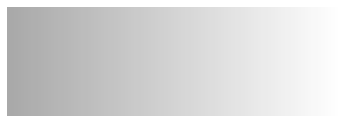

In [21]:
from matplotlib.colors import LinearSegmentedColormap

# Define the colormap
cmap_name = 'darkgraywhite'
colors = [(0, "darkgray"), (1, "white")]
n_bins = 100  # Discretizes the interpolation into bins
cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)

# Test the colormap
gradient = np.linspace(0, 1, 256).reshape(1, -1)
gradient = np.vstack((gradient, gradient))

fig, ax = plt.subplots(figsize=(6, 2))
ax.imshow(gradient, aspect='auto', cmap=cm)
ax.set_axis_off()
plt.show()

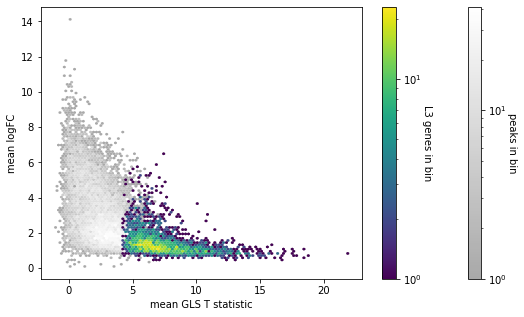

In [22]:
fig, ax = plt.subplots( figsize=(4.5*2, 2.5*2))
extent = [x.min(), x.max(), y.min(), y.max()]
m = ax.hexbin(x, y, cmap=cm, linewidths=0, gridsize=100,
               rasterized=True,
              
               edgecolors='black', mincnt=1, bins='log',
              extent=extent)

cbar = ax.figure.colorbar(m, ax=ax)
cbar.set_label('peaks in bin',
                       rotation=270,
                       labelpad=10)

im = ax.hexbin(x.loc[cons_genes], y.loc[cons_genes],
               gridsize=100,
           # cmap='summer', 
               rasterized=True,
                cmap='viridis',
               linewidths=0,
            bins='log',
               edgecolors='black', mincnt=1, 
           extent=extent,
          )
cbar = ax.figure.colorbar(im, ax=ax)
cbar.set_label('L3 genes in bin',
                       rotation=270,
                       labelpad=10)
ax.set_xlabel('mean GLS T statistic')
ax.set_ylabel('mean logFC')
plt.savefig("../../figures/gex_cons_vs_div_l3_highlight.pdf", transparent=True, dpi=500, bbox_inches='tight')

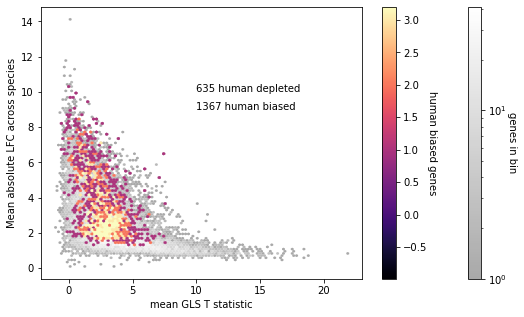

In [25]:
extent = [x.min(), x.max(), y.min(), y.max()]
fig, ax = plt.subplots( figsize=(4.5*2, 2.5*2))
im = ax.hexbin(x, y, cmap=cm, linewidths=0, gridsize=100,
               edgecolors='black', mincnt=1, bins='log',
               rasterized=True,
               
              extent=extent)

cbar = ax.figure.colorbar(im, ax=ax)
cbar.set_label('genes in bin',
                       rotation=270,
                       labelpad=10)
ax.set_xlabel('mean GLS T statistic')
ax.set_ylabel('mean Minium abosolute LFC in most divergence cell type')
# plt.savefig("../../figures/atac_cons_vs_div_graywhite.pdf", transparent=True, dpi=500, bbox_inches='tight')

# fig, ax = plt.subplots( figsize=(4*2, 2.5*2))
im = ax.hexbin(x[x.index.isin(human_divergent)], y[x.index.isin(human_divergent)], 
               cmap='magma', linewidths=.3, gridsize=100,
               edgecolors='face', mincnt=1,
               rasterized=True,
               
              extent=extent)

im.set_clim(3.2, -.9)


cbar = ax.figure.colorbar(im, ax=ax)
cbar.set_label('human biased genes',
                       rotation=270,
                       labelpad=10)
ax.text(10, 9, '1367 human biased')
ax.text(10, 10, '635 human depleted')

ax.set_xlabel('mean GLS T statistic')
ax.set_ylabel('Mean absolute LFC across species')
plt.savefig("../../figures/gex_human_divergent.pdf", transparent=True, dpi=400)

In [23]:
x[x.index.isin(human_divergent)].idxmax()

'NR4A2'

In [24]:
phastcons = pd.read_csv('../../data/ref/average_exon_phastcons.tsv', sep='\t').set_index('GeneSymbol')

(13218,) (13218,)


Text(0.5, 1.0, 'GLS T-statistic vs Phastcons')

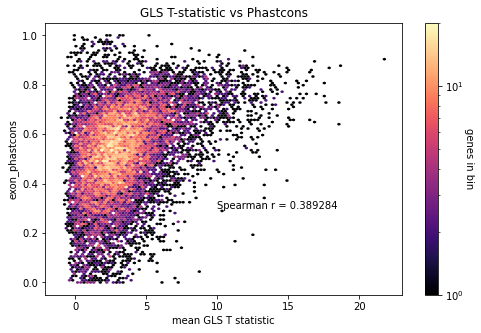

In [58]:
fig, ax = plt.subplots(figsize=(4*2, 2.5*2))
div = []
cons = []
for pair in pairs_use:
    spec1, spec2 = pair
    # if 'human' not in pair:
    #     continue
    
    stats = pd.read_csv('../../data/outputs/gex_gls_results/gls_{}_{}.tsv'.format(spec1, spec2), sep='\t').set_index('human_gene')
    de = pd.read_csv(out_f.format(test_use, spec1, spec2), sep='\t').set_index('Unnamed: 0')
    stats, de = common_index(stats, de)
    div.append(de.abs().max(axis=1))
    cons.append(stats.t_val)
div = pd.concat(div, axis=1)
cons = pd.concat(cons, axis=1).fillna(0)

x = cons.mean(axis=1)
y = phastcons.loc[phastcons.notna().values]['Conservation']

# use = y.notna()

x, y = common_index(x, y)

print(x.shape, y.shape)

r = spearmanr(x, y, nan_policy='omit')[0]
im = ax.hexbin(x.values, y.values, cmap='magma', bins='log', linewidths=0)
cbar = ax.figure.colorbar(im, ax=ax)
cbar.set_label('genes in bin',
                       rotation=270,
                       labelpad=10)
ax.set_xlabel('mean GLS T statistic')
ax.set_ylabel('exon_phastcons')
ax.text(10, 0.3, 'Spearman r = {:4f}'.format(r), size=10)
ax.set_title('GLS T-statistic vs Phastcons')
# plt.savefig("../../figures/gex_cons_vs_div_human_phastcons.pdf", transparent=True, dpi=500)

(13218,) (13218,)


Text(0.5, 1.0, 'GLS T-statistic vs Phastcons')

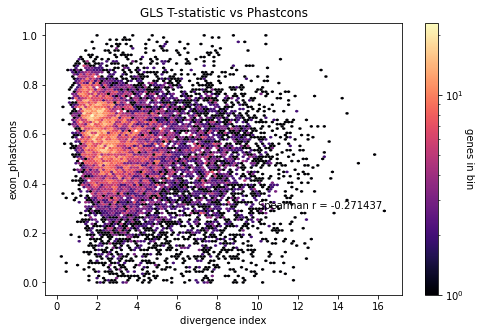

In [59]:
fig, ax = plt.subplots(figsize=(4*2, 2.5*2))
div = []
cons = []
for pair in pairs_use:
    spec1, spec2 = pair
    # if 'human' not in pair:
    #     continue
    
    stats = pd.read_csv('../../data/outputs/gex_gls_results/gls_{}_{}.tsv'.format(spec1, spec2), sep='\t').set_index('human_gene')
    de = pd.read_csv(out_f.format(test_use, spec1, spec2), sep='\t').set_index('Unnamed: 0')
    stats, de = common_index(stats, de)
    div.append(de.abs().max(axis=1))
    cons.append(stats.t_val)
div = pd.concat(div, axis=1)
cons = pd.concat(cons, axis=1).fillna(0)

x = div.max(axis=1)
# cons.mean(axis=1)
y = phastcons.loc[phastcons.notna().values]['Conservation']

# use = y.notna()

x, y = common_index(x, y)

print(x.shape, y.shape)

r = spearmanr(x, y, nan_policy='omit')[0]
im = ax.hexbin(x.values, y.values, cmap='magma', bins='log', linewidths=0)
cbar = ax.figure.colorbar(im, ax=ax)
cbar.set_label('genes in bin',
                       rotation=270,
                       labelpad=10)
ax.set_xlabel('divergence index')
ax.set_ylabel('exon_phastcons')
ax.text(10, 0.3, 'Spearman r = {:4f}'.format(r), size=10)
ax.set_title('GLS T-statistic vs Phastcons')
# plt.savefig("../../figures/gex_cons_vs_div_human_phastcons.pdf", transparent=True, dpi=500)